# Import

In [2]:
import matplotlib.pyplot as plt
from os.path import join

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns

sns.set(font_scale = 2.5)
sns.set_style("white") 

# Input

In [3]:
root = '../scratch/TFT_baseline/figures/'
attention = pd.read_csv(join(root, 'attention.csv'))
attention['Date'] = pd.to_datetime(attention['Date'])
attention.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,Date,FIPS
0,0.005,0.022,0.177,0.004,0.008,0.038,0.490,0.093,0.067,0.069,0.003,0.007,0.018,2020-03-13,10001
1,0.129,0.001,0.010,0.057,0.023,0.101,0.336,0.089,0.001,0.009,0.062,0.026,0.155,2020-03-14,10001
2,0.091,0.018,0.003,0.006,0.150,0.064,0.395,0.041,0.008,0.002,0.004,0.131,0.088,2020-03-15,10001


In [5]:
max_encoder_length = 13
encoder_indices = list(range(max_encoder_length))
attention.rename(
    {str(index):index for index in encoder_indices}, 
    axis=1, inplace=True
)

# Temporal

In [27]:
attention_date_aligned = pd.DataFrame(attention[['FIPS', 'Date']])
for i in range(max_encoder_length):
    attention_date_aligned[i] = attention[i].shift(
        periods=i-max_encoder_length, fill_value=0
    )

In [86]:
attention_date_aligned_summed = attention_date_aligned.groupby('Date')[
    encoder_indices
].aggregate('sum').reset_index()

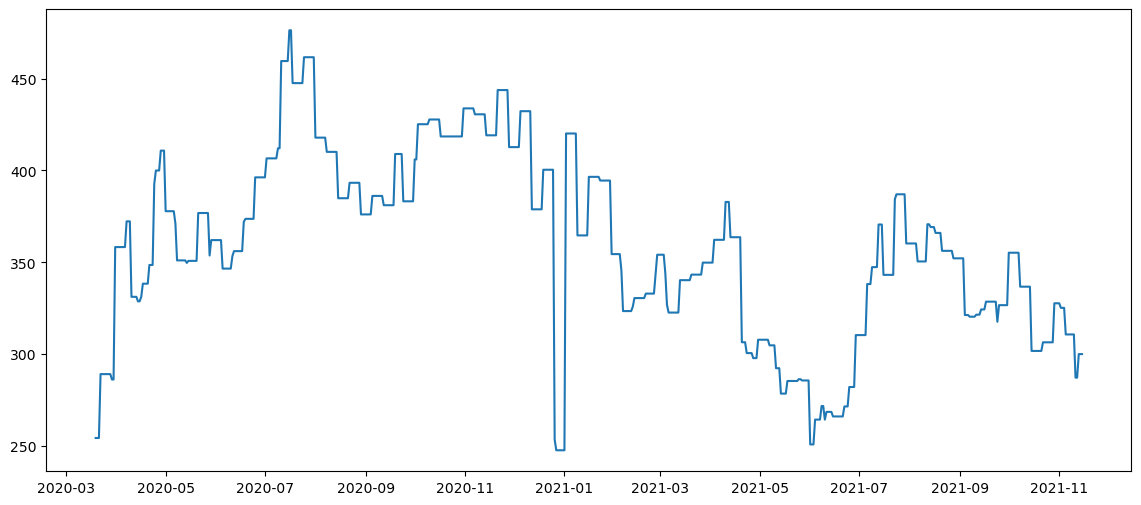

In [101]:
plt.figure(figsize=(14, 6))
plt.plot(
    attention_date_aligned_summed['Date'],
    attention_date_aligned_summed[12].rolling(7, axis=0).mean()
)

# Spatial

## Sum up attention across time

In [6]:
attention_summed = attention.groupby(['FIPS'])[
    encoder_indices
].aggregate('sum').reset_index()
attention_summed['Sum'] = attention_summed[encoder_indices].sum(axis=1)
attention_summed.describe()

,FIPS,0,1,2,3,4,5,6,7,8,9,10,11,12,Sum
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.00000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,30383.649268,26.468939,10.946461,9.682496,13.761549,23.12945,44.762808,272.883687,53.057159,20.084210,13.768467,18.659849,37.365306,68.356756,612.927136
std,15162.508374,3.486447,1.764973,1.845226,1.547030,2.13308,3.503657,9.869651,3.511619,2.151106,2.542931,2.775233,3.731330,5.417071,0.032735
min,1001.000000,17.741000,7.184000,3.517000,5.913000,15.42400,31.840000,233.504000,41.885000,14.507000,3.804000,6.769000,24.942000,41.243000,612.820000
25%,18177.500000,24.084000,9.630500,8.552500,13.000250,21.92100,42.656500,268.313500,50.745250,18.577250,12.617750,17.146500,35.092500,65.151250,612.906000
50%,29176.000000,26.028500,10.622000,9.853000,14.013500,23.04300,44.325500,273.020000,52.605500,19.933500,14.272500,18.970000,37.496000,68.512500,612.925000
75%,45080.500000,28.361000,12.069750,10.925500,14.792250,24.35100,46.192250,278.040000,55.134750,21.378750,15.426500,20.714750,40.007750,71.467500,612.948000
max,56045.000000,44.620000,20.459000,14.583000,18.212000,31.86300,63.534000,314.065000,66.562000,29.669000,21.409000,26.004000,48.389000,92.836000,613.094000


## Select particular day for attention weight

In [51]:
# create a shorter version
# only use yesterday's encoder attention 
# since using too aggregated results might not be usefull
df = pd.DataFrame({
    'FIPS':attention_summed['FIPS'],
    'Attention Weight': attention_summed[6]
})

## Social Vulnerability Index

In [11]:
svi = pd.read_csv('../../dataset_raw/Support files/SVI2020_US_COUNTY.csv')
svi['density'] = svi['E_TOTPOP'] / svi['AREA_SQMI']
svi.describe()

,ST,STCNTY,FIPS,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,M_UNEMP,E_HBURD,M_HBURD,E_NOHSDP,M_NOHSDP,E_UNINSUR,M_UNINSUR,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_LIMENG,M_LIMENG,E_MINRTY,M_MINRTY,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV150,MP_POV150,EP_UNEMP,MP_UNEMP,EP_HBURD,MP_HBURD,EP_NOHSDP,MP_NOHSDP,EP_UNINSUR,MP_UNINSUR,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_LIMENG,MP_LIMENG,EP_MINRTY,MP_MINRTY,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV150,EPL_UNEMP,EPL_HBURD,EPL_NOHSDP,EPL_UNINSUR,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,EPL_LIMENG,SPL_THEME2,RPL_THEME2,EPL_MINRTY,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV150,F_UNEMP,F_HBURD,F_NOHSDP,F_UNINSUR,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_LIMENG,F_THEME2,F_MINRTY,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_DAYPOP,E_NOINT,M_NOINT,E_AFAM,M_AFAM,E_HISP,M_HISP,E_ASIAN,M_ASIAN,E_AIAN,M_AIAN,E_NHPI,M_NHPI,E_TWOMORE,M_TWOMORE,E_OTHERRACE,M_OTHERRACE,EP_NOINT,MP_NOINT,EP_AFAM,MP_AFAM,EP_HISP,MP_HISP,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,density
count,3143.000000,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3.143000e+03,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.00000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,30.271079,30374.576519,30374.576519,1124.096939,1.039037e+05,7.750875,4.404478e+04,129.369074,3.892912e+04,404.629653,2.142605e+04,1137.330576,2822.308622,301.958320,1.058763e+04,527.012727,8.133210e+03,482.360802,8927.426981,654.895323,1.666014e+04,72.392619,2.332063e+04,45.889596,1.297692e+04,627.700286,2509.951639,262.701559,4.061988e+03,293.966911,4.146291e+04,958.423481,6047.581610,289.320395,2664.504932,280.972956,1291.965956,164.551702,3291.288896,259.593064,2568.671333,269.246580,24.486828,3.129749,5.197996,1.635794,22.282342,3.216577,12.395514,1.902418,9.539548,1.846134,19.227935,0.584951,22.083710,0.510340,15.991505,1.828985,5.879033,1.697168,1.621540,0.867579,24.249061,2.729971,4.786001,

### Scatter plot

Text(0, 0.5, 'Attention Weight')

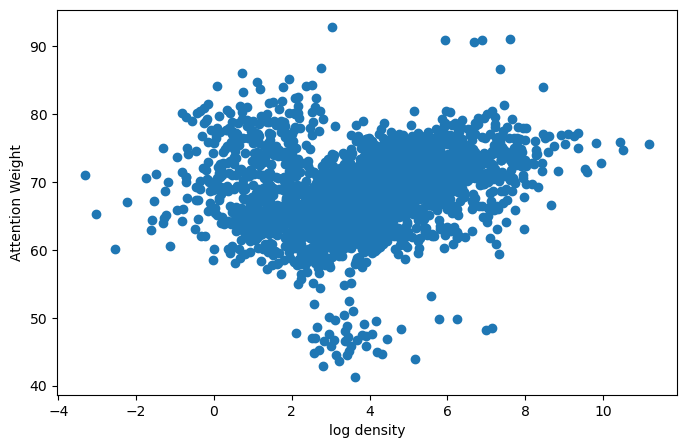

In [12]:
variable_name ='density'
plt.figure(figsize=(8, 5))
merged = svi[['FIPS', variable_name]].merge(df, on='FIPS', how='inner')

plt.scatter(np.log(merged[variable_name]), merged['Attention Weight'])
plt.xlabel(f'log {variable_name}')

# plt.scatter(merged[variable_name], merged['Attention Weight'])
# plt.xlabel(variable_name)
plt.ylabel('Attention Weight')
# plt.scatter(merged[variable_name], np.log(merged['Attention Weight']))

### Scatter with distribution

In [13]:
from scipy.stats import gaussian_kde

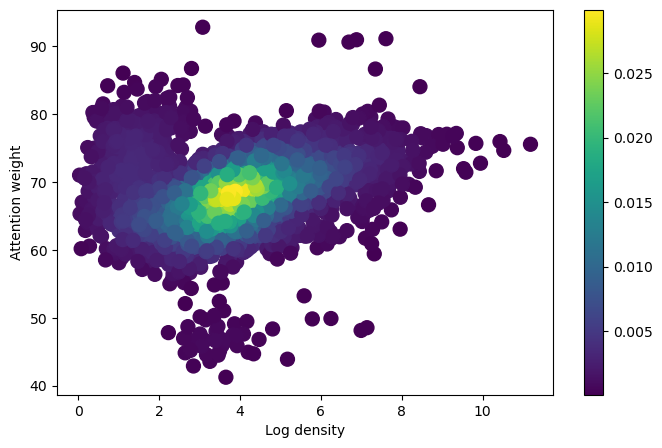

In [14]:
plt.figure(figsize=(8, 5))
x = np.log1p(merged[variable_name])
y = merged['Attention Weight']

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=z, s=100)
plt.xlabel(f'Log {variable_name}')
plt.ylabel('Attention weight')
plt.colorbar()

## High vs low attention counties

Partition the counties into two groups by median attention. Then take the difference of their statistics and show the significantly different ones.

In [131]:
attention_median = df['Attention Weight'].median()
# partition into groups based on attention weights
higher_attention = df[df['Attention Weight']>=attention_median]
lower_attention = df[df['Attention Weight']<attention_median]

df['Class'] = 'High'
df.loc[df['Attention Weight']<attention_median, 'Class'] = 'Low'

df.describe()

,FIPS,Attention Weight
count,3142.000000,3142.000000
mean,30383.649268,272.883687
std,15162.508374,9.869651
min,1001.000000,233.504000
25%,18177.500000,268.313500
50%,29176.000000,273.020000
75%,45080.500000,278.040000
max,56045.000000,314.065000


In [132]:
merged = df.merge(
    svi[['FIPS', 'LOCATION', 'AREA_SQMI',	'E_TOTPOP']],
    on='FIPS', how='inner'
).sort_values(by='Attention Weight').reset_index(drop=True)

### Counties with least attention

In [133]:
merged[:20]

,FIPS,Attention Weight,Class,LOCATION,AREA_SQMI,E_TOTPOP
0,42089,233.504,Low,"Monroe County, Pennsylvania",608.356576,168824
1,42095,237.596,Low,"Northampton County, Pennsylvania",369.787512,304233
2,36105,238.008,Low,"Sullivan County, New York",968.144643,75329
3,17183,238.116,Low,"Vermilion County, Illinois",898.318402,76704
4,36111,238.479,Low,"Ulster County, New York",1124.235496,178371
5,42103,238.515,Low,"Pike County, Pennsylvania",544.895187,55660
6,42003,238.523,Low,"Allegheny County, Pennsylvania",729.953564,1218380
7,42075,238.793,Low,"Lebanon County, Pennsylvania",361.835069,140410
8,36085,238.962,Low,"Richmond County, New York",57.522511,475596
9,42091,239.348,Low,"Montgomery County, Pennsylvania",482.970298,827180


### Counties with most attention

In [134]:
merged[-20:]

,FIPS,Attention Weight,Class,LOCATION,AREA_SQMI,E_TOTPOP
3121,20095,307.742,High,"Kingman County, Kansas",863.418716,7173
3122,20107,307.798,High,"Linn County, Kansas",594.080747,9687
3123,20177,307.968,High,"Shawnee County, Kansas",544.025491,177293
3124,20005,308.220,High,"Atchison County, Kansas",431.174217,16210
3125,20121,308.587,High,"Miami County, Kansas",575.878495,33740
3126,20205,308.593,High,"Wilson County, Kansas",570.421590,8600
3127,20041,309.124,High,"Dickinson County, Kansas",847.067386,18614
3128,20061,309.624,High,"Geary County, Kansas",384.662954,33309
3129,20149,309.667,High,"Pottawatomie County, Kansas",840.739870,24203
3130,20057,309.696,High,"Ford County, Kansas",1098.270321,33718


## SVI differences

### Merge attention with SVI

In [135]:
# merge the attentions with the SVI features
higher_merged = higher_attention.merge(svi, on='FIPS', how='inner')
lower_merged = lower_attention.merge(svi, on='FIPS', how='inner')

# select the socio-economic features with percentage 
higher_stats = higher_merged[[col for col in svi.columns if col.startswith('EPL_')]].describe()
lower_stats = lower_merged[[col for col in svi.columns if col.startswith('EPL_')]].describe()

diff = higher_stats - lower_stats
diff

,EPL_POV150,EPL_UNEMP,EPL_HBURD,EPL_NOHSDP,EPL_UNINSUR,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,EPL_LIMENG,EPL_MINRTY,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ
count,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
mean,0.12342,0.069334,-0.069726,0.102984,0.149526,-0.039924,0.062616,0.102177,0.037990,0.001900,0.049476,-0.086601,0.139990,0.097294,-0.020720,-0.009489
std,0.00622,0.008374,-0.024171,0.019503,0.023765,0.022365,0.027836,0.013219,0.014328,0.011401,-0.003577,-0.002791,-0.010541,-0.000914,-0.002028,0.013572
min,-0.00130,0.000000,-0.001300,-0.000600,-0.000300,-0.000600,-0.000300,-0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.14095,0.052500,-0.060750,0.087550,0.134300,-0.082200,0.036600,0.097400,0.019100,0.000000,0.057600,-0.092600,0.172200,0.076300,-0.031200,-0.038800
50%,0.18310,0.099900,-0.113800,0.155300,0.198900,-0.070800,0.112400,0.145950,0.041000,0.000000,0.082100,-0.127600,0.205600,0.163300,-0.029000,-0.022300
75%,0.14100,0.096600,-0.102425,0.137200,0.195700,-0.021300,0.106600,0.133225,0.065500,0.018400,0.049100,-0.102200,0.147400,0.113300,-0.034450,0.007700
max,0.00100,-0.000600,-0.003200,0.000300,-0.000300,0.000600,-0.000300,0.000300,-0.000300,0.000300,0.001000,-0.001600,0.000600,-0.000300,-0.001600,-0.000300


In [136]:
# features with significant median difference in socio-economic scales
diff.loc[:, abs(diff.loc['50%'].round(2))>=0.15]

,EPL_POV150,EPL_NOHSDP,EPL_UNINSUR,EPL_MOBILE,EPL_CROWD
count,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000
mean,0.12342,0.102984,0.149526,0.139990,0.097294
std,0.00622,0.019503,0.023765,-0.010541,-0.000914
min,-0.00130,-0.000600,-0.000300,0.000000,0.000000
25%,0.14095,0.087550,0.134300,0.172200,0.076300
50%,0.18310,0.155300,0.198900,0.205600,0.163300
75%,0.14100,0.137200,0.195700,0.147400,0.113300
max,0.00100,0.000300,-0.000300,0.000600,-0.000300


In [70]:
significantly_different_columns = list(
    diff.loc[:, abs(diff.loc['50%'])>0.15].columns
)
print(significantly_different_columns)

merged = df.merge(
    svi[['FIPS']+significantly_different_columns], 
    on='FIPS', how='inner'
)

In [92]:
merged2 = []
for col in significantly_different_columns:
    temp = pd.DataFrame({
        'Class': merged['Class'],
        'Feature': col,
        'Value': merged[col]
    })

    merged2.append(temp)

merged2 = pd.concat(merged2, axis=0)

### Boxplot

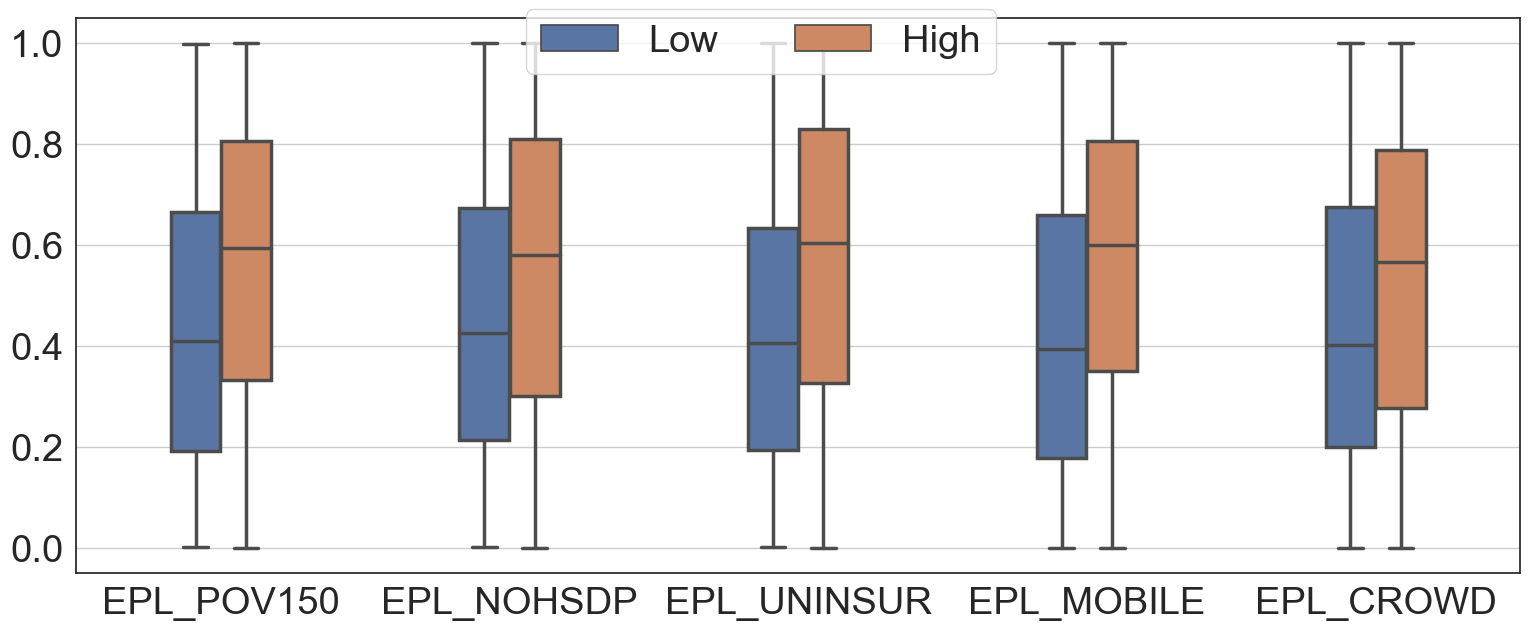

In [149]:
plt.figure(figsize=(16, 7))
sns.boxplot(
    x = 'Feature', y = 'Value', hue='Class', 
    data = merged2, linewidth=2.5, width=0.35
)
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper right', ncol=2, bbox_to_anchor=(0.65, 1.05),fancybox=True)
plt.tight_layout()
plt.savefig(join(root, 'Attention_comparison_SVI.jpg'), dpi=200)

## County Health Ranking

In [142]:
health = pd.read_csv('../../Archives/dataset_additional (not used)/cleaned/Health rank measure.csv')
health.head(3)

,FIPS,Years of Potential Life Lost Rate,% Fair or Poor Health,% Smokers,% Adults with Obesity,Primary Care Physicians Rate,% Flu Vaccinated,% Unemployed,Average Daily PM2.5,% Severe Housing Problems
0,1001,8128.591190,20.882987,18.081557,33.3,45.04180,41.0,3.629079,11.7,14.663462
1,1003,7354.122530,17.509134,17.489033,31.0,72.89727,44.0,3.615382,10.3,13.566201
2,1005,10253.573403,29.591802,21.999985,41.7,31.65809,37.0,5.171384,11.5,14.583333


In [143]:
from sklearn.preprocessing import MinMaxScaler

health_features = [
    col for col in health.columns if col!='FIPS'
]

# scale down within [0, 1] range
health[health_features] = MinMaxScaler().fit_transform(health[health_features])

In [145]:
# merge the attentions with the SVI features
higher_merged = higher_attention.merge(health, on='FIPS', how='inner')
lower_merged = lower_attention.merge(health, on='FIPS', how='inner')

# select the socio-economic features with percentage 
higher_stats = higher_merged[health_features].describe()
lower_stats = lower_merged[health_features].describe()

diff = higher_stats - lower_stats

# No significant difference found.
diff

,Years of Potential Life Lost Rate,% Fair or Poor Health,% Smokers,% Adults with Obesity,Primary Care Physicians Rate,% Flu Vaccinated,% Unemployed,Average Daily PM2.5,% Severe Housing Problems
count,49.000000,0.000000,0.000000,0.000000,3.000000,-4.000000,-1.000000,6.000000,0.000000
mean,0.026941,0.057437,0.029979,0.015819,-0.016033,-0.035986,0.014140,-0.014000,0.002611
std,-0.000989,0.012261,0.005156,-0.005923,-0.007131,-0.000132,0.003411,-0.015252,-0.014462
min,-0.002230,0.034805,0.041110,-0.011038,0.000000,-0.016129,0.012779,-0.023952,0.005892
25%,0.025555,0.050964,0.018957,0.013245,-0.011216,-0.032258,0.012210,-0.005988,0.011183
50%,0.033712,0.072507,0.038557,0.013245,-0.014822,-0.048387,0.013255,-0.005988,0.007049
75%,0.028426,0.066637,0.039909,0.013245,-0.020200,-0.032258,0.016565,-0.035928,0.002431
max,-0.021157,0.084096,0.013781,-0.088300,-0.161419,0.016129,-0.248314,-0.395210,-0.280520
